<a href="https://colab.research.google.com/github/SaloWi/cas_mod4/blob/main/M6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## M6 Project

#### Mayra and Salomé

**1. Introduction**

Medical insurance pricing is influenced by multiple factors, including demographic and lifestyle variables. In this project, we analyze a dataset containing information about individuals' insurance charges alongside features such as age, BMI, smoking status, children, and gender.

**2. Dataset Overview**

The dataset consists of the following key variables:

**Age:** The age of the individual.

**BMI (Body Mass Index):** A measure of body fat based on height and weight.

**Gender:** The biological sex of the individual (e.g., male, female).

**Children:** The amount of children an individual has.

**Smoker:** Whether the individual is a smoker (yes/no).

**Region:** The geographical region where the individual resides.

**Charges:** The total medical insurance cost for the individual.


**3. Objective**

The goal of this project is to build a predictive model using a neural network to estimate insurance charges based on the given features. By doing so, we aim to:


*   Identify the most significant factors affecting insurance costs.

*   Assess how well a neural network can predict charges compared to other models.
*   Understand the impact of lifestyle choices (e.g., smoking) on pricing.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error

import torch.nn as nn
import torch.optim as optim
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pickle


In [6]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [7]:
# Load dataset
data = pd.read_csv('insurance.csv')  # Replace with your dataset's name
# Display the first few rows
print(data.head())
# Check for missing values
print(data.isnull().sum())
# Basic statistics
print(data.describe())
# Display data types
print(data.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000  

### Descriptives

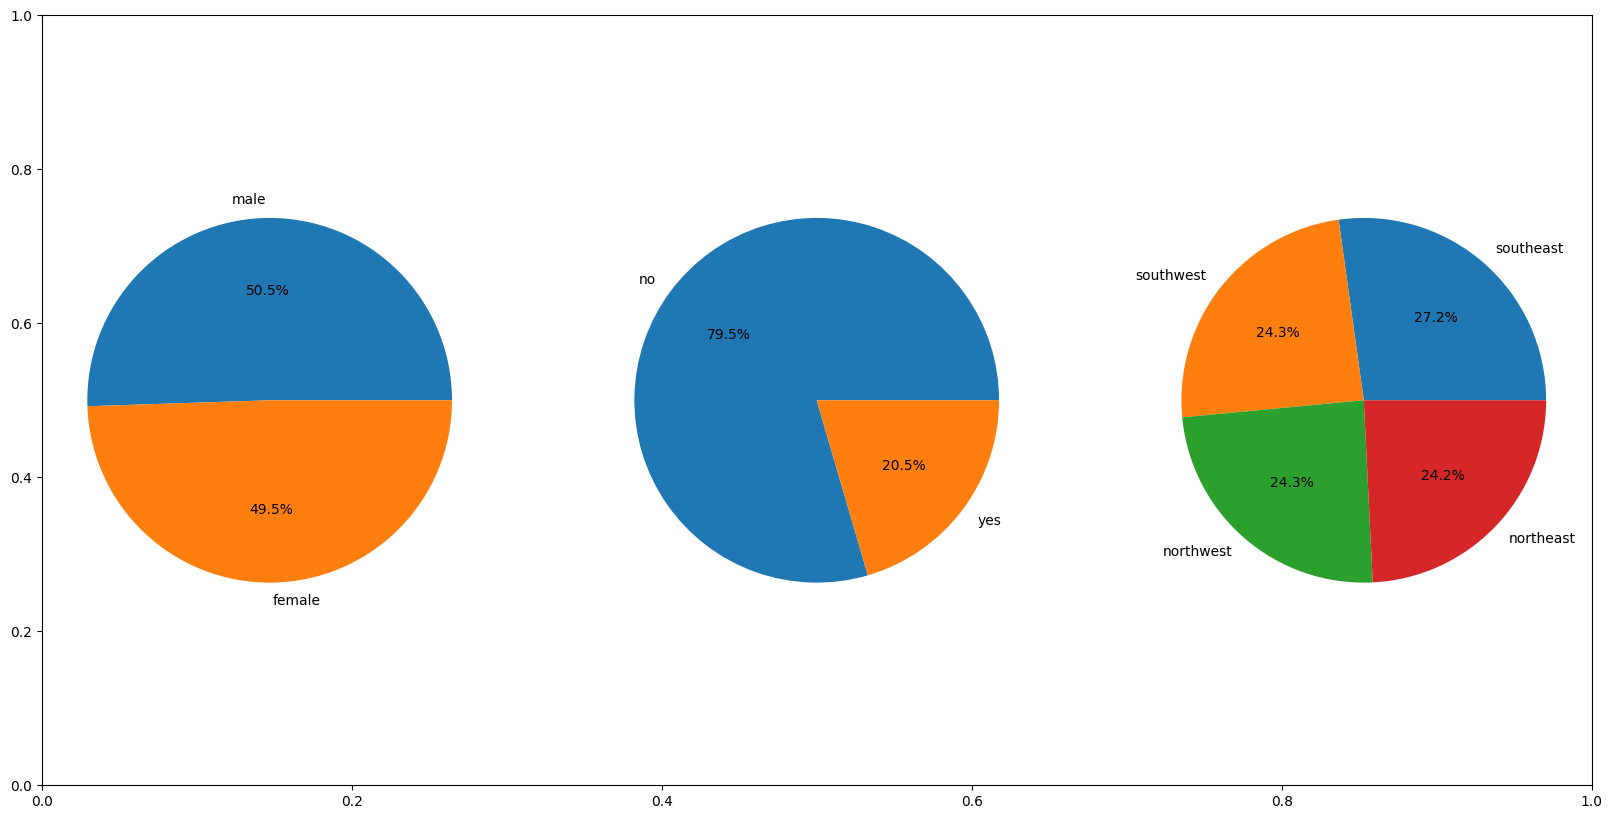

In [8]:
import matplotlib.pyplot as plt
features = ['sex', 'smoker', 'region']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)

    x = data[col].value_counts()
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')

plt.show()

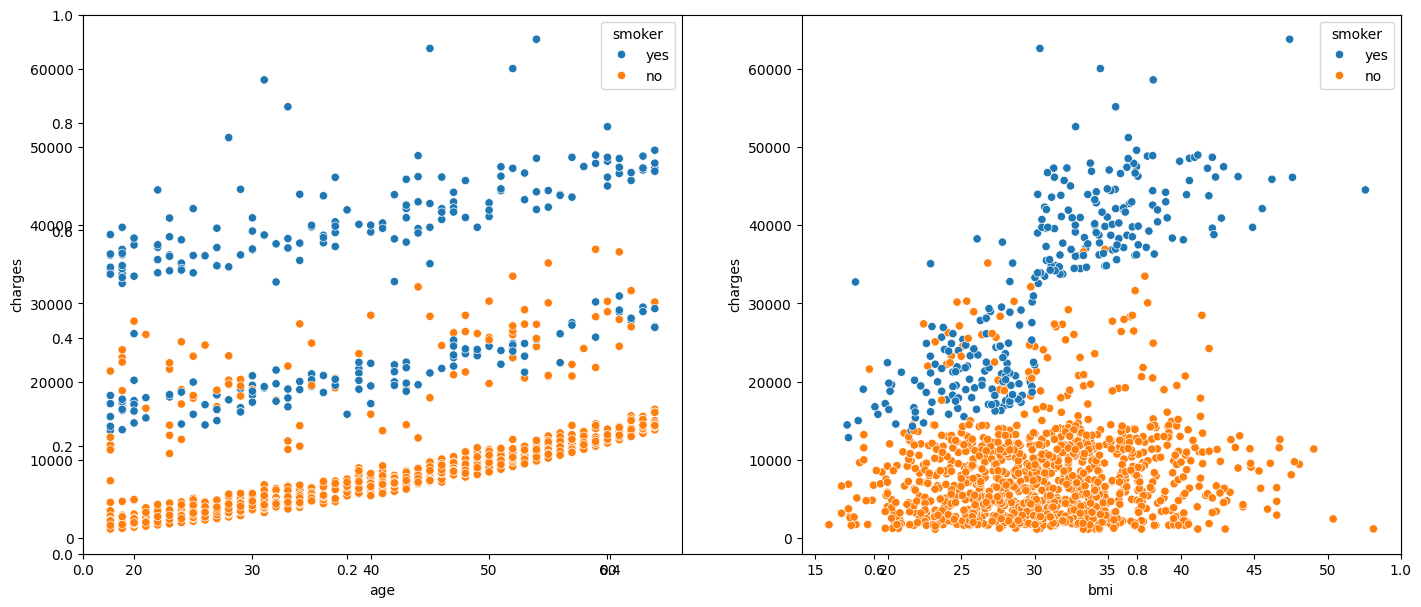

In [9]:
import seaborn as sns

features = ['age', 'bmi']

plt.subplots(figsize=(17, 7))
for i, col in enumerate(features):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=data, x=col,
                   y='charges',
                   hue='smoker')
plt.show()

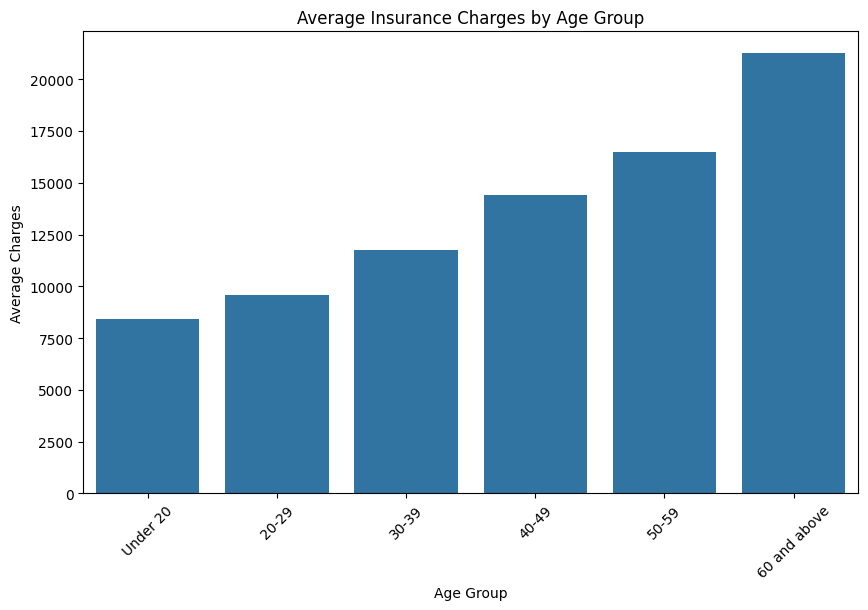

In [10]:
def age_group(age):
    if age < 20:
        return 'Under 20'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    else:
        return '60 and above'
data['age_group'] = data['age'].apply(age_group)
average_cost_by_age_group = data.groupby('age_group')['charges'].mean()

age_order = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and above']

plt.figure(figsize=(10, 6))
sns.barplot(x=average_cost_by_age_group.index, y=average_cost_by_age_group.values, order=age_order)
plt.title('Average Insurance Charges by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Charges')
plt.xticks(rotation=45)
plt.show()

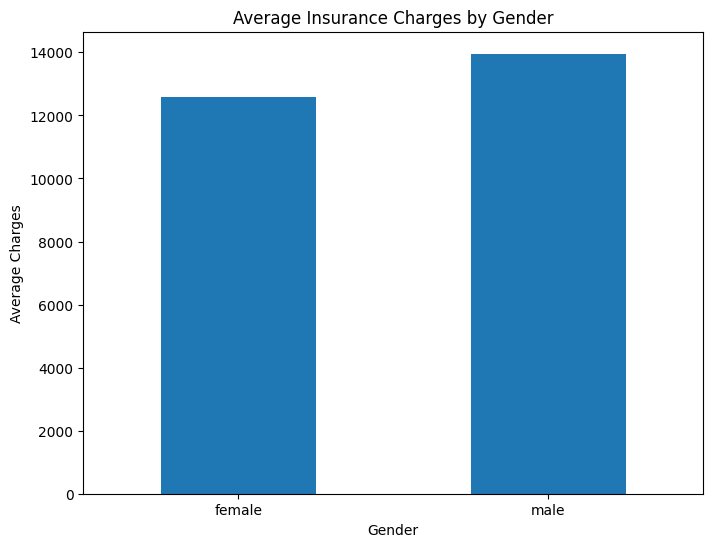

In [12]:
average_cost_by_sex = data.groupby('sex')['charges'].mean()

plt.figure(figsize=(8, 6))
average_cost_by_sex.plot(kind='bar')
plt.title('Average Insurance Charges by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Charges')
plt.xticks(rotation=0)
plt.show()

### Prepare data for NN

In [30]:
# Encode categorical variables
categorical_columns = ['sex', 'smoker', 'region']
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
# Features and target variable
X = data.drop(columns=['charges', 'age_group'])  # Features
y = data['charges']                 # Target (insurance cost)
# Normalize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [31]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE and MAE for regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [33]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Adjust epochs as needed
    batch_size=32
)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 317540128.0000 - mae: 13104.4297 - val_loss: 323352384.0000 - val_mae: 12965.9053
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 322791328.0000 - mae: 13223.1084 - val_loss: 323202144.0000 - val_mae: 12961.1436
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 336770080.0000 - mae: 13471.8115 - val_loss: 322877504.0000 - val_mae: 12951.3193
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 294690688.0000 - mae: 12759.6592 - val_loss: 322280096.0000 - val_mae: 12933.9209
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 331482016.0000 - mae: 13609.5645 - val_loss: 321279872.0000 - val_mae: 12905.9150
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 311404576.0000 - mae: 13136.5566 - val_loss: 319765408.0000 - val_mae: 12864.8086
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 318270816.0000 - mae: 13228.9834 - val_loss: 317550336.0000 - val_mae: 12806.3408
Epoch 8/50
34/34 ━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29714822.0000 - mae: 3883.4792 
Test Loss (MSE): 32482648.0
Test Mean Absolute Error (MAE): 4018.11474609375
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


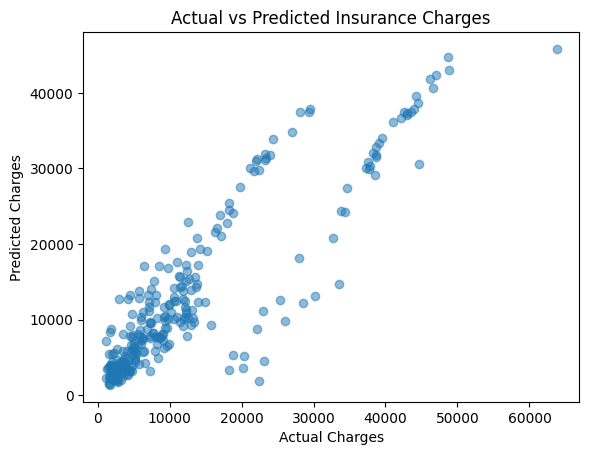

In [34]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions
y_pred = model.predict(X_test)
# Compare predictions vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()


In [41]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape * 100:.2f}%')

MAPE: 44.24%


## Different Model

In [15]:
data.sample(20)

,age,sex,bmi,children,smoker,region,charges,age_group
303,28,0,33.000,2,0,2,4349.46200,20-29
779,53,1,28.880,0,0,1,9869.81020,50-59
1004,47,1,19.190,1,0,0,8627.54110,40-49
563,50,1,44.770,1,0,2,9058.73030,50-59
18,56,1,40.300,0,0,3,10602.38500,50-59
1188,43,0,25.270,1,1,0,21771.34230,40-49
1138,33,1,30.250,0,0,2,3704.35450,30-39
980,54,1,25.460,1,0,0,25517.11363,50-59
1335,18,0,36.850,0,0,2,1629.83350,Under 20
768,64,0,39.700,0,0,3,14319.03100,60 and above


In [45]:
data['sex'] = LabelEncoder().fit_transform(data['sex'])
data['smoker'] = LabelEncoder().fit_transform(data['smoker'])

In [46]:
print(data.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_group'],
      dtype='object')


In [47]:
data_encoded = pd.get_dummies(data, columns=['region'])

In [48]:
X = data_encoded.drop(['charges', 'age_group'], axis=1)
y = data_encoded['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [50]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [51]:
# Model Building and Training
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

model = RegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
epochs = 240
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/240], Loss: 81845456.0000
Epoch [20/240], Loss: 86522952.0000
Epoch [30/240], Loss: 70445272.0000
Epoch [40/240], Loss: 96630632.0000
Epoch [50/240], Loss: 26422782.0000
Epoch [60/240], Loss: 19582116.0000
Epoch [70/240], Loss: 33761704.0000
Epoch [80/240], Loss: 17389426.0000
Epoch [90/240], Loss: 25258618.0000
Epoch [100/240], Loss: 14230499.0000
Epoch [110/240], Loss: 7953708.0000
Epoch [120/240], Loss: 8996633.0000
Epoch [130/240], Loss: 19526984.0000
Epoch [140/240], Loss: 22980790.0000
Epoch [150/240], Loss: 12538105.0000
Epoch [160/240], Loss: 4427954.5000
Epoch [170/240], Loss: 7635865.5000
Epoch [180/240], Loss: 23396484.0000
Epoch [190/240], Loss: 61633656.0000
Epoch [200/240], Loss: 7014822.5000
Epoch [210/240], Loss: 76037240.0000
Epoch [220/240], Loss: 11353895.0000
Epoch [230/240], Loss: 15612837.0000
Epoch [240/240], Loss: 8151588.0000


In [53]:
# Evaluating the Model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f'Actual: {actual.item()}, Predicted: {predicted.item()}')

Test Loss: 29238762.0000
Actual: 15006.5791015625, Predicted: 17306.794921875
Actual: 4766.02197265625, Predicted: 5957.53125
Actual: 8944.115234375, Predicted: 11800.7529296875
Actual: 13880.94921875, Predicted: 14981.1416015625
Actual: 13228.8466796875, Predicted: 15012.4912109375
Actual: 11264.541015625, Predicted: 12124.5400390625
Actual: 3594.1708984375, Predicted: 4559.736328125
Actual: 18972.494140625, Predicted: 23509.48046875
Actual: 20296.86328125, Predicted: 25954.30859375
Actual: 25656.576171875, Predicted: 10229.7783203125


In [54]:
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()

mape = mean_absolute_percentage_error(y_test_np, y_pred_np)
print(f'MAPE: {mape * 100:.2f}%')

MAPE: 34.10%


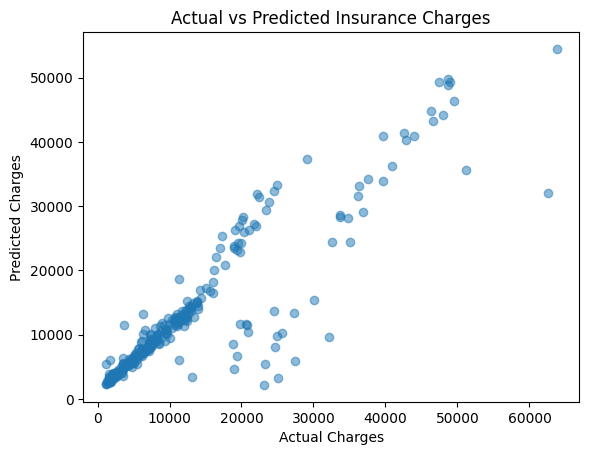

In [55]:
# Compare predictions vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test_np, y_pred_np, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()


In [56]:
fig = px.box(data, x='region', y='charges', color='smoker', title='Interactive Boxplot of Charges by Region and Smoking Status')
fig.show()



## Summary
**Age and BMI** have a strong positive correlation with insurance charges.

**Smoking** is the most influential factor affecting charges.

**Regions** have only a minor impact.